## Keras Unsupervised
Unsupervised clustering of MNIST using KMenas, Autoencoder to produce embedding + KMeans and DEC (Unsupervised Deep Embedding for Clustering Analysis).

DEC: https://arxiv.org/abs/1511.06335

In [18]:
import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K

from time import time

from keras import callbacks
from keras.datasets import mnist
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.utils import np_utils

import matplotlib.pyplot as plt

from scipy.misc import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score

Load the mnist data and show a few samples

In [13]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [14]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


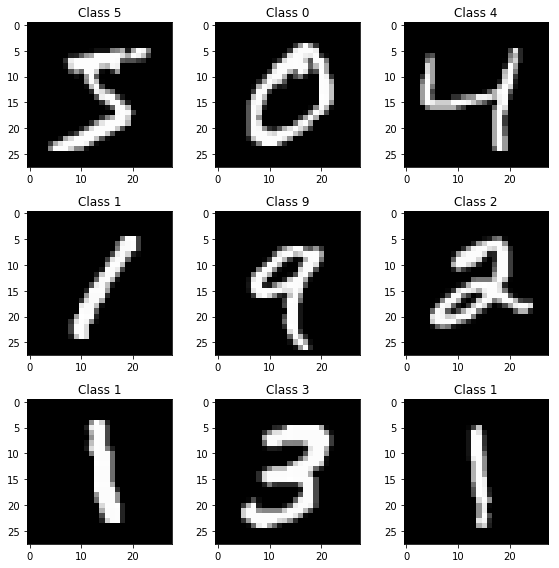

In [15]:
fig=plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title("Class {}".format(y_train[i]))
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
plt.tight_layout()

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [16]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

Finally, the output variable is an integer from 0 to 9. As this is a multi-class classification problem we need to one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in np_utils.to_categorical() helper function in Keras.

In [19]:
# one hot encode outputs and save original classes
print(y_train.shape)
print(y_test.shape)
print(y_train[:10])
y_train_classes = y_train.copy()
y_test_classes = y_test.copy()
y_train = np_utils.to_categorical(y_train_classes)
y_test = np_utils.to_categorical(y_test_classes)
num_classes = y_test.shape[1]
print(y_train.shape)
print(y_test.shape)
print(y_train[:3])

(60000,)
(10000,)
[5 0 4 1 9 2 1 3 1 4]
(60000, 10)
(10000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## K-Means with 10 clusters

The training dataset is structured as a 3-dimensional array of (instance, image width and image height). Our neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector.

We can do this transform easily using the reshape() function on the NumPy array. We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway.

In [28]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train_reshaped = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test_reshaped = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(60000, 784)
(10000, 784)


In [20]:
km = KMeans(n_jobs=-1, n_clusters=10, n_init=20)

In [23]:
km.fit(X_train_reshaped)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=20, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
pred = km.predict(X_test_reshaped)

We will use Normalized Mutual Information (NMI) score to evaluate our model.
Mutual information is a symmetric measure for the degree of dependency between the clustering and the manual classification. It is based on the notion of cluster purity pi, which measures the quality of a single cluster Ci, the largest number of objects in cluster Ci which Ci has in common with a manual class Mj, having compared Ci to all manual classes in M. Because NMI is normalized, we can use it to compare clusterings with different numbers of clusters.

In [27]:
normalized_mutual_info_score(y_test_classes, pred)

0.49920798984923836

## Autoencoder
Instead of directly applying K-Means on the dataset, we will first use an autoencoder to decrease the dimensionality of the data and extract useful information. We will then use this embedding to pass on to the K-Means algorithm.

In [32]:
# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784)(decoded)

#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [33]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_11 (Dense)             (None, 2000)              1002000   
_________________________________________________________________
dense_12 (Dense)             (None, 10)                20010     
_________________________________________________________________
dense_13 (Dense)             (None, 2000)              22000     
_________________________________________________________________
dense_14 (Dense)             (None, 500)               1000500   
__________

Fit the model

In [36]:
history = autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=50, batch_size=2048, validation_data=(X_test_reshaped, X_test_reshaped))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 16s 271us/step - loss: 0.0153 - val_loss: 0.0157
Epoch 2/50
60000/60000 [==============================] - 16s 266us/step - loss: 0.0152 - val_loss: 0.0158
Epoch 3/50
60000/60000 [==============================] - 16s 259us/step - loss: 0.0151 - val_loss: 0.0158
Epoch 4/50
60000/60000 [==============================] - 16s 269us/step - loss: 0.0151 - val_loss: 0.0155
Epoch 5/50
60000/60000 [==============================] - 15s 258us/step - loss: 0.0150 - val_loss: 0.0155
Epoch 6/50
60000/60000 [==============================] - 15s 255us/step - loss: 0.0150 - val_loss: 0.0155
Epoch 7/50
60000/60000 [==============================] - 16s 261us/step - loss: 0.0148 - val_loss: 0.0154
Epoch 8/50
60000/60000 [==============================] - 16s 261us/step - loss: 0.0149 - val_loss: 0.0155
Epoch 9/50
60000/60000 [==============================] - 17s 287us/step - loss: 0.0148 - val_

Predict the embedded format for the training set using only the encoder part of the network and train the K-Means using this

In [39]:
pred_auto_train = encoder.predict(X_train_reshaped)
km.fit(pred_auto_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=20, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Predict using the test set.

In [40]:
pred_auto = encoder.predict(X_test_reshaped)
pred = km.predict(pred_auto)

In [43]:
normalized_mutual_info_score(y_test_classes, pred)

0.7414710645948941

## DEC
State-of-the-art model – known as DEC algorithm. This algorithm trains both clustering and autoencoder models to get better performance.
DEC Code from: https://github.com/XifengGuo/DEC-keras

In [72]:
def accuracy(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [73]:
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:

Original Author:
    Xifeng Guo. 2017.1.30
"""


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (accuracy(self.y, y_pred), normalized_mutual_info_score(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: ', time() - t0)
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(accuracy(y, y_pred), 5)
                    nmi = np.round(normalized_mutual_info_score(y, y_pred), 5)
                    ari = np.round(adjusted_rand_score(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred

In [74]:
# setting the hyper parameters
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
dataset = 'mnist'
batch_size = 2048
maxiter = 2e4
tol = 0.001
save_dir = 'results'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

update_interval = 200
pretrain_epochs = 20 #500
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#pretrain_optimizer = SGD(lr=1, momentum=0.9)


# prepare the DEC model
dec = DEC(dims=[X_train_reshaped.shape[-1], 500, 500, 2000, 10], n_clusters=10, init=init)

dec.pretrain(x=X_train_reshaped, y=y_train_classes, optimizer=pretrain_optimizer,
             epochs=pretrain_epochs, batch_size=batch_size,
             save_dir=save_dir)

...Pretraining...
Epoch 1/20
60000/60000 [==============================] - 15s 250us/step - loss: 0.0748
        |==>  acc: 0.1892,  nmi: 0.1051  <==|
Epoch 2/20
60000/60000 [==============================] - 14s 237us/step - loss: 0.0636
Epoch 3/20
60000/60000 [==============================] - 14s 236us/step - loss: 0.0629
        |==>  acc: 0.3910,  nmi: 0.2941  <==|
Epoch 4/20
60000/60000 [==============================] - 15s 252us/step - loss: 0.0541
Epoch 5/20
60000/60000 [==============================] - 16s 267us/step - loss: 0.0474
        |==>  acc: 0.4658,  nmi: 0.4160  <==|
Epoch 6/20
60000/60000 [==============================] - 17s 290us/step - loss: 0.0401
Epoch 7/20
60000/60000 [==============================] - 17s 289us/step - loss: 0.0347
        |==>  acc: 0.5547,  nmi: 0.5237  <==|
Epoch 8/20
60000/60000 [==============================] - 17s 289us/step - loss: 0.0311
Epoch 9/20
60000/60000 [==============================] - 18s 308us/step - loss: 0.0288
      

In [75]:
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,665,110
Trainable params: 1,665,110
Non-trainable params: 0
_________________________________________________________________


In [76]:
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [78]:
y_pred = dec.fit(X_train_reshaped, y=y_train_classes, tol=tol, maxiter=maxiter, batch_size=batch_size,
                 update_interval=update_interval, save_dir=save_dir)

Update interval 200
Save interval 146.484375
Initializing cluster centers with k-means.
Iter 0: acc = 0.69502, nmi = 0.61950, ari = 0.53423  ; loss= 0
saving model to: results/DEC_model_0.h5
Iter 200: acc = 0.70308, nmi = 0.62660, ari = 0.54858  ; loss= 0
Iter 400: acc = 0.70738, nmi = 0.63395, ari = 0.55879  ; loss= 0
Iter 600: acc = 0.71025, nmi = 0.64341, ari = 0.56714  ; loss= 0
Iter 800: acc = 0.71378, nmi = 0.65335, ari = 0.57532  ; loss= 0
Iter 1000: acc = 0.71602, nmi = 0.66052, ari = 0.58028  ; loss= 0
Iter 1200: acc = 0.71755, nmi = 0.66547, ari = 0.58373  ; loss= 0
Iter 1400: acc = 0.71943, nmi = 0.66971, ari = 0.58691  ; loss= 0
Iter 1600: acc = 0.72147, nmi = 0.67373, ari = 0.59025  ; loss= 0
Iter 1800: acc = 0.72342, nmi = 0.67680, ari = 0.59269  ; loss= 0
Iter 2000: acc = 0.72528, nmi = 0.67963, ari = 0.59492  ; loss= 0
Iter 2200: acc = 0.72697, nmi = 0.68164, ari = 0.59712  ; loss= 0
Iter 2400: acc = 0.72812, nmi = 0.68329, ari = 0.59847  ; loss= 0
Iter 2600: acc = 0.72

In [79]:
pred_val = dec.predict(X_test_reshaped)

In [80]:
normalized_mutual_info_score(y_test_classes, pred_val)

0.6981151525389725